**IMPORT LIB  AND CONFIG HERE**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from scipy import stats
from scipy.signal import correlate
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, coint
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# đang ssh server, nên chưa set up CUDA, cuDNN, phiên bản phù hợp được, nên tạm thời không train LSTM

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline

**I. DATA PROCESSING**



*1.1 Fetch data and handle missing, and make data enrichment*

*1.1.1 VNINDEX*

In [3]:
with open('data/case2_index.json', 'r') as f:
    data1 = json.load(f)
    df_vnindex = pd.DataFrame(data1)

df_vnindex['TradingDate'] = pd.to_datetime(df_vnindex['TradingDate'])
df_vnindex = df_vnindex.sort_values('TradingDate').reset_index(drop=True)
df_vnindex = df_vnindex.set_index('TradingDate')  

df_vnindex = df_vnindex.ffill()  


In [4]:
df_vnindex.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1387 entries, 2020-01-02 to 2025-07-24
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ComGroupCode        1387 non-null   object 
 1   IndexValue          1387 non-null   float64
 2   PercentIndexChange  1387 non-null   float64
 3   TotalMatchValue     1387 non-null   float64
 4   TotalValue          1387 non-null   float64
dtypes: float64(4), object(1)
memory usage: 65.0+ KB


After that, we have `ComGroupCode`', '`IndexValue`', '`PercentIndexChange`', '`TotalMatchValue`','`TotalValue`' aligned time period from 2020-01-02 to 2025-07-24

*1.1.2 Interest_rate_data*


*Collect additional interest rate data from case1, I assume interest_rate which is one of most impact investor expected and directly effect on market price movement, so I used to in case2, I hope it's no problem and conflict your requirements.*

In [5]:
df_interest = pd.read_csv("data/case1_interest.csv")
df_interest.rename(columns={df_interest.columns[0]: "date"}, inplace=True)
df_interest["date"] = pd.to_datetime(df_interest["date"], format="%m/%Y")

# Rút gọn tên cột cho tiện sử dụng
df_interest.columns = df_interest.columns.str.strip()
column_mapping = {
    "Lãi suất huy động bình quân": "huy_dong_avg",
    "Lãi suất huy động bình quân trên 12 tháng (thấp nhất)": "huy_dong_12m_min",
    "Lãi suất huy động bình quân trên 12 tháng (cao nhất)": "huy_dong_12m_max",
    "Lãi suất cho vay bình quân": "cho_vay_avg",
    "Cho vay VND ngắn hạn (thấp nhất)": "cv_vnd_short_min",
    "Cho vay VND ngắn hạn (cao nhất)": "cv_vnd_short_max",
    "Cho vay VND trung và dài hạn (thấp nhất)": "cv_vnd_long_min",
    "Cho vay VND trung và dài hạn (cao nhất)": "cv_vnd_long_max",
    "Cho vay USD ngắn hạn (thấp nhất)": "cv_usd_short_min",
    "Cho vay USD ngắn hạn (cao nhất)": "cv_usd_short_max",
    "Cho vay USD trung và dài hạn (thấp nhất)": "cv_usd_long_min",
    "Cho vay USD trung và dài hạn (cao nhất)": "cv_usd_long_max",
}

df_interest.rename(columns=column_mapping, inplace=True)
for col in df_interest.columns:
    if col != "date":
        df_interest[col] = df_interest[col].astype(str).str.replace("%", "").str.strip()  # Chuyển các cột số về dạng float, bỏ dấu %
        df_interest[col] = pd.to_numeric(df_interest[col], errors="coerce")

df_interest['cv_vnd_long_min'].ffill(inplace= True)
df_interest['cv_vnd_long_max'].ffill(inplace= True)

"""Làm giàu dữ liệu để tạo feature, giải thích ý nghĩa phía dưới"""
df_interest['huy_dong_avg'] = (df_interest['huy_dong_12m_min'] + df_interest['huy_dong_12m_max']) / 2
df_interest['VND_borrow_interest_average_shorterm'] = (df_interest['cv_vnd_short_min'] + df_interest['cv_vnd_short_max']) / 2
df_interest['VND_borrow_interest_average_longterm'] = (df_interest['cv_vnd_long_min'] + df_interest['cv_vnd_long_max']) / 2
df_interest['USD_borrow_interest_average_shorterm'] = (df_interest['cv_usd_short_min'] + df_interest['cv_usd_short_max']) / 2
df_interest['USD_borrow_interest_average_longterm'] = (df_interest['cv_usd_long_min'] + df_interest['cv_usd_long_max']) / 2
df_interest['spead_shortterm'] = df_interest['VND_borrow_interest_average_shorterm'] - df_interest['USD_borrow_interest_average_shorterm']
df_interest['spead_longterm'] = df_interest['VND_borrow_interest_average_longterm'] - df_interest['USD_borrow_interest_average_longterm']


In [6]:
df_interest

,date,huy_dong_avg,huy_dong_12m_min,huy_dong_12m_max,cho_vay_avg,cv_vnd_short_min,cv_vnd_short_max,cv_vnd_long_min,cv_vnd_long_max,cv_usd_short_min,cv_usd_short_max,cv_usd_long_min,cv_usd_long_max,VND_borrow_interest_average_shorterm,VND_borrow_interest_average_longterm,USD_borrow_interest_average_shorterm,USD_borrow_interest_average_longterm,spead_shortterm,spead_longterm
0,2020-01-01,7.05,6.6,7.50,NaN,6.0,9.0,9.0,11.0,3.0,4.70,4.5,6.0,7.5,10.00,3.850,5.25,3.650,4.75
1,2020-02-01,7.05,6.6,7.50,NaN,6.0,9.0,9.0,11.0,3.0,4.70,4.5,6.0,7.5,10.00,3.850,5.25,3.650,4.75
2,2020-03-01,7.02,6.6,7.44,NaN,6.0,9.0,9.0,11.0,3.0,4.70,4.5,6.0,7.5,10.00,3.850,5.25,3.650,4.75
3,2020-04-01,7.00,6.6,7.40,NaN,6.0,9.0,9.0,11.0,3.0,4.63,4.4,6.0,7.5,10.00,3.815,5.20,3.685,4.80
4,2020-05-01,7.00,6.6,7.40,NaN,6.0,9.0,9.0,11.0,3.0,4.50,4.2,6.0,7.5,10.00,3.750,5.10,3.750,4.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2025-03-01,5.40,4.8,6.00,NaN,4.0,4.0,6.6,9.0,4.2,5.00,0.0,0.0,4.0,7.80,4.600,0.00,-0.600,7.80
62,2025-04-01,5.40,4.8,6.00,NaN,4.0,4.0,6.6,8.9,4.2,5.00,0.0,0.0,4.0,7.75,4.600,0.00,-0.600,7.75
63,2025-05-01,5.40,4.8,6.00,NaN,4.0,4.0,6.6,8.9,4.1,5.00,0.0,0.0,4.0,7.75,4.550,0.00,-0.550,7.75
64,2025-06-01,5.45,4.8,6.10,NaN,4.0,4.0,6.5,8.8,4.1,5.00,0.0,0.0,4.0,7.65,4.550,0.00,-0.550,7.65


For enriching interest_rate data, I have some ideas such as:
  -  Spread (VN_borrow_interest_rate - USD_borrow_interest_rate) = `VND_borrow_interest_average_shorterm` - `USD_borrow_interest_average_shorterm`
    " I assume that the spread indicate liquidity of VND, as same as cost of fund VND and cost of fund in swap contract USD to VND.
    
    --> To Assume, high spread => VND costly => bank NIM tăng => rally

  - The correlationship between `VND_borrow_interest_average_shorterm` and `USD_borrow_interest_average_shorterm` with VNINDEX price index as expanding moneytary policy in shorterm by SBV Goverment.
  

*1.1.3 Banking data*

In [7]:
with open('data/case2_stock_input.json', 'r') as f:
    data2 = json.load(f)
    df_bank = pd.DataFrame(data2)
df_bank['TradingDate'] = pd.to_datetime(df_bank['TradingDate'])
df_bank = df_bank.sort_values(['TradingDate', 'Ticker']).reset_index(drop=True)


"""Làm giàu dữ liệu Proxy Bank"""
df_bank['volume_indiv_buy'] = df_bank['LocalIndividualBuyTradingValue'] + df_bank['ForeignIndividualBuyTradingValue'] 
df_bank['volume_indiv_sell'] = df_bank['LocalIndividualSellTradingValue'] + df_bank['ForeignIndividualSellTradingValue']
df_bank['volume_insti_buy'] = df_bank['LocalInstitutionalBuyTradingValue'] + df_bank['ForeignInstitutionalBuyTradingValue']
df_bank['volume_insti_sell'] = df_bank['LocalInstitutionalSellTradingValue'] + df_bank['ForeignInstitutionalSellTradingValue']


df_bank['log_return'] = df_bank.groupby('Ticker')['ClosePriceAdjusted'].transform(lambda x: np.log(x) - np.log(x.shift(1)))
df_bank['log_return'].replace([np.inf, -np.inf], np.nan, inplace=True)

"""Agg cho toàn bank sector , lấy TTV"""
df_bank_agg = df_bank.groupby('TradingDate').agg({
    'TotalMatchValue': 'sum',
    'TotalValue': 'sum',
    'volume_indiv_buy': 'sum',
    'volume_indiv_sell': 'sum',
    'volume_insti_buy': 'sum',
    'volume_insti_sell': 'sum',
    'log_return': 'mean'
}).reset_index()

df_bank_agg = df_bank_agg.set_index('TradingDate')

In [8]:
df_bank_agg

,TotalMatchValue,TotalValue,volume_indiv_buy,volume_indiv_sell,volume_insti_buy,volume_insti_sell,log_return
TradingDate,,,,,,,
2020-01-02,3.893380e+11,4.344061e+11,3.352913e+11,3.507793e+11,5.831948e+10,7.994657e+10,NaN
2020-01-03,3.350400e+11,3.387566e+11,2.800000e+11,3.108588e+11,4.918346e+10,2.624646e+10,-0.006031
2020-01-06,3.599590e+11,4.166190e+11,2.884159e+11,3.678574e+11,1.211292e+11,4.671497e+10,-0.014340
2020-01-07,3.560940e+11,4.531595e+11,3.265297e+11,3.552118e+11,1.168540e+11,9.660663e+10,0.006609
2020-01-08,6.114310e+11,1.854448e+12,4.850247e+11,6.300164e+11,1.361546e+12,1.218122e+12,-0.008904
...,...,...,...,...,...,...,...
2025-07-18,9.294153e+12,9.750041e+12,4.023431e+12,3.988977e+12,5.726610e+12,5.761064e+12,0.009725
2025-07-21,8.639318e+12,9.553914e+12,4.699037e+12,4.929343e+12,4.854877e+12,4.624571e+12,0.006784
2025-07-22,7.723822e+12,8.175852e+12,4.073594e+12,3.988308e+12,4.102258e+12,4.187545e+12,0.013678


In [ ]:

df_bank_agg['net_indiv'] = df_bank_agg['volume_indiv_buy'] - df_bank_agg['volume_indiv_sell']
df_bank_agg['net_insti'] = df_bank_agg['volume_insti_buy'] - df_bank_agg['volume_insti_sell']
df_bank_agg['total_volume'] = df_bank_agg['volume_indiv_buy'] + df_bank_agg['volume_indiv_sell'] + df_bank_agg['volume_insti_buy'] + df_bank_agg['volume_insti_sell']

# imbalance ratio for individuals vs institutional
df_bank_agg['indiv_ratio'] = (df_bank_agg['volume_indiv_buy'] + df_bank_agg['volume_indiv_sell']) / df_bank_agg['total_volume']
df_bank_agg['insti_ratio'] = 1 - df_bank_agg['indiv_ratio'] 

# Volatility (rolling std returns, window=5 for short-term risk)
df_bank_agg['bank_volatility'] = df_bank_agg['log_return'].rolling(window=5, min_periods=1).std()

# Momentum (cumulative returns for lead indicator)
df_bank_agg['bank_cum_return'] = np.exp(df_bank_agg['log_return'].cumsum()) - 1 # dung exponential

# Lagged features for time-series models
for col in ['log_return', 'net_indiv', 'net_insti', 'total_volume']:
    for lag in range(1, 6):
        df_bank_agg[f'{col}_lag{lag}'] = df_bank_agg[col].shift(lag)

df_bank_agg.dropna(inplace=True)

additional enrich data:
    - Net flow both individuals (indiv) and institutional (insti) by calculated volume_buy - volume_sell. In each, imbalance ratio between individuals and institutional
    - Volatitlity of bank return by rolling 5 days window to smooth  and cummulative return
    - 

Insight:
     Net_indiv positive thường precede rally (tâm lý cá nhân dẫn dắt, VN-specific: Cá nhân chiếm 80% volume HOSE, dễ herd). Volatility spike => overbought, contribute to LSTM input as risk feature.

1.2 Align data

In [ ]:
df_merged = df_bank_agg.join(df_vnindex, how='inner', lsuffix='_bank', rsuffix='_vnindex')

# Tính GTGD_bank_percent (thanh khoản bank / toàn thị trường)
df_merged['GTGD_bank_percent'] = (df_merged['TotalMatchValue_bank'] / df_merged['TotalMatchValue_vnindex']) * 100 

if 'date' in df_interest.columns:
    df_interest.set_index('date', inplace=True)
df_interest_daily = df_interest.resample('D').ffill().reset_index()
df_interest_daily = df_interest_daily.set_index('date')

# Merge interest
df_merged = df_merged.join(df_interest_daily, how='left')

# Tính VNIndex log_return for consistency
df_merged['vn_log_return'] = np.log(df_merged['IndexValue'].pct_change() + 1)

# Non-bank proxy returns (assume bank weight ~35% in VNIndex)
bank_weight = 0.35
df_merged['non_bank_return'] = (df_merged['vn_log_return'] - bank_weight * df_merged['log_return']) / (1 - bank_weight)

In [12]:
df_merged['vn_log_return']

TradingDate
2020-01-10         NaN
2020-01-13   -0.002792
2020-01-14    0.001200
2020-01-15    0.000579
2020-01-16    0.006952
                ...   
2025-07-18    0.004867
2025-07-21   -0.008202
2025-07-22    0.016357
2025-07-23    0.001833
2025-07-24    0.005743
Name: vn_log_return, Length: 1381, dtype: float64

In [ ]:
# Check stationarity for all key series (ADF, vì non-stationary gây spurious reg)
for col in ['GTGD_bank_percent', 'log_return', 'vn_log_return', 'spead_shortterm', 'net_indiv', 'net_insti']:
    if col in df_merged.columns:
        adf = adfuller(df_merged[col].dropna())
        print(f'ADF for {col}: stat={adf[0]}, p-value={adf[1]}')  

ADF for GTGD_bank_percent: stat=-3.9785558858760677, p-value=0.0015270565387123433
ADF for log_return: stat=-15.402346511817674, p-value=3.2028039777573373e-28
ADF for vn_log_return: stat=-15.804809977255635, p-value=1.0635799407926319e-28
ADF for spead_shortterm: stat=-2.297241116567917, p-value=0.17285931030801072
ADF for net_indiv: stat=-8.631546440652505, p-value=5.737535521919418e-14
ADF for net_insti: stat=-8.71302210650661, p-value=3.548890075431132e-14


Các biến `log_return`, `vn_log_return`, `net_indiv`, `net_insti`, `GTGD_bank_percent` đều dừng (stationary) manh, dùng được cho hồi quy, VAR, Granger.

Riêng `spead_shortterm` không dừng, nên cần lấy sai phân (diff) nếu dùng trong hồi quy hoặc kiểm định liên quan.

**II. Hypothesis and Evaluation**

**Hypothesis 1: Xác định Giai đoạn Bank-led Rally (>30% GTGD)**

Giả thuyết: Rally khi GTGD >30%, smooth để avoid noise (rolling mean).


Method: Threshold + rolling vì data volatile (holidays VN), t-test để confirm difference significant (công thức: t = (mean1 - mean2) / sqrt(var1/n1 + var2/n2)).


Output: Rally binary as label cho LSTM classify/predict phases.

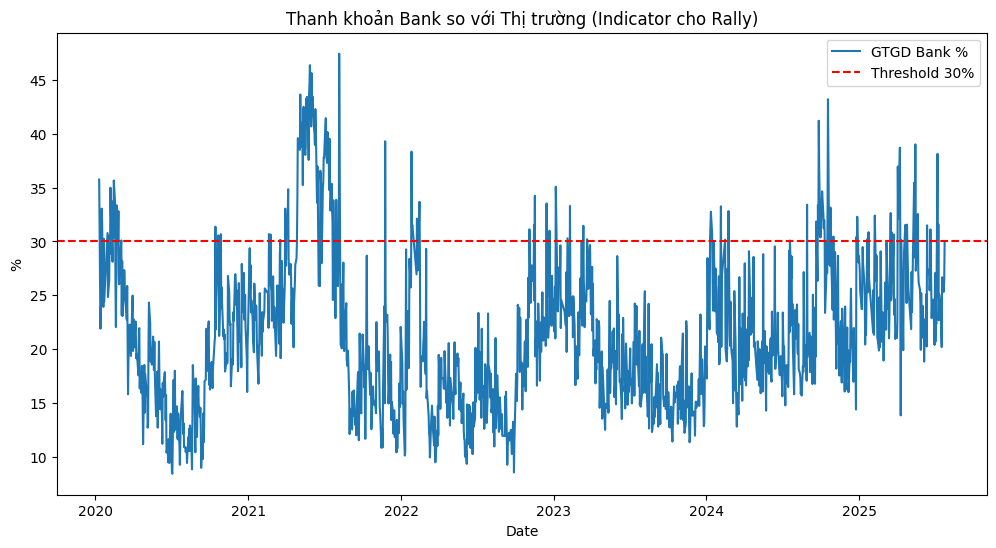

In [14]:

plt.figure(figsize=(12,6))
plt.plot(df_merged.index, df_merged['GTGD_bank_percent'], label='GTGD Bank %')
plt.axhline(30, color='r', linestyle='--', label='Threshold 30%')
plt.title('Thanh khoản Bank so với Thị trường (Indicator cho Rally)')
plt.xlabel('Date')
plt.ylabel('%')
plt.legend()
plt.show()

df_merged['GTGD_smooth'] = df_merged['GTGD_bank_percent'].rolling(3, min_periods=1).mean()
df_merged['bank_led_rally'] = (df_merged['GTGD_smooth'] > 30).astype(int)

| Giai Đoạn                  | Description                                                 | Duration          | GTGD Peak (%) |
|-----------------------------|---------------------------------------------------------------|----------------------------|---------------|
| Q1-Q2 2021 (tháng 3-6/2021) | Spike đầu tiên lớn, vượt 30% liên tục 4-6 tuần, cao nhất ~45%. | ~1-2 tháng                 | ~45%          |
| Q4 2022 (tháng 10-12/2022)    | Spike trung bình, vượt 30% ngắn (2-3 tuần), ~35%.             | ~1 tháng                   | ~35%          |
| Q1-Q2 2023 (tháng 5-8/2023) | Spike rõ, vượt 30% với peak ~38%, kéo dài hơn.                 | ~1.5 tháng                 | ~38%          |
| Q1 & Q4 /2024 (tháng 1-3 and thang 10 -12 /2024)    | Spike nhỏ hơn, vượt 30% ngắn, ~32%.                           | ~2-3 tuần                  | ~32%          |
| Mid-2025 (tháng 4-6/2025)   | Spike mới nhất, vượt 30% với momentum tăng, ~36%.             | ~1 tháng (đang diễn ra)    | ~36%          |


Explain in each period "Bank rally VNINDEX" 

| Giai Đoạn                  | Nguyên Nhân Kinh Tế/Chính Sách                                                                                                                                                                                                                                                                         | Tâm Lý NĐT                                                                                                         | Indication (all in the past nhe)                                                                                       |
|-----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| Q1-Q2 2021 (tháng 3-6/2021) | Post-COVID recovery: SBV cắt giảm lãi suất huy động xuống 4-5% (thấp nhất 15 năm), tăng credit growth target 12-14%. GDP rebound 2.6% Q1 (World Bank). FDI tăng do supply chain shift từ China.                                                                 | Bullish sentiment: Retail đổ tiền vào bank (VCB, BID) do undervalued P/E ~8x, FOMO từ VNIndex breakout 1,200.        | Bank lead đầu tiên mạnh (chiếm 40% cap VNIndex), liquidity focus kéo VNIndex +20% Q2. Lead khi policy easing + recovery. |
|  Q4 2022 (tháng 10-12/2022)   | Global inflation nhưng VN resilient: SBV giữ lãi suất thấp (4.5%), nới room tín dụng cho bank. Export +10% YoY (manufacturing boom).                                                                                                                           | Cautious nhưng retail buy dip: Sentiment từ "bank-led" post-Omicron, volume cá nhân spike 30%.                       | Bank outperform non-bank (returns +15% vs +5%), lead do NIM tăng từ low funding costs. Lead khi internal growth > global risks. |
| Q1-Q2 2023 (tháng 5-8/2023) | SBV giảm lãi suất thêm (0.5-1%), target credit 14%. Inflation control <4%, GDP 5.5% H1. FDI record 20B USD (semicon, EV).                                                                                                                                    | Optimism từ policy: Retail herd vào bank do P/B <1.5x, social media buzz (X/Twitter về "bank rally").                 | Bank kéo VNIndex +10%, lead sector rõ (GTGD >35%). Lead khi FDI + monetary support.                                |
| Q1 & Q4 /2024 (tháng 1-3 and thang 10 -12 /2024)     | Transition year: SBV ổn định rates ~5%, nhưng credit growth chậm (10%). Kinh tế 6% YoY, trade surplus.                                                                                                                                                         | Mixed sentiment: Retail cautious post-2023 peak, nhưng institutional buy bank undervalued.                           | Rally yếu hơn, bank lead ngắn (chỉ +5% VNIndex). Lead khi stable policy, không easing mạnh.                        |
| Mid-2025 (tháng 4-6/2025)   | Recent boom: SBV raise credit target 16% (từ 14%, Fitch Ratings), GDP forecast 6.6% (World Bank Sep 2025). Services/manufacturing +7.5% H1, US tariffs nhưng VN diversify.                                                                                      | Upbeat: Bullish từ "bank stocks on radar" (Diễn Đàn Doanh Nghiệp Aug 2025), retail + institutional optimism post-global easing. | Bank propel VNIndex +1-2% weekly (VIR Sep 2025), lead do leverage tăng (Fitch warning risks). Lead khi credit expansion + resilient growth. |


In [15]:
# Kiểm định: t-test returns rally vs non
rally_returns = df_merged[df_merged['bank_led_rally']==1]['vn_log_return']
non_returns = df_merged[df_merged['bank_led_rally']==0]['vn_log_return']

rally_returns = rally_returns.dropna()
non_returns = non_returns.dropna()
t_stat, p_val = stats.ttest_ind(rally_returns, non_returns)
print(f't-test: stat={t_stat}, p={p_val}')

t-test: stat=-0.8120675164336381, p=0.4168931475189507


t-test độc lập (H0: mean vn_log_return rally = non-rally; t = (mean_rally - mean_non) / sqrt(var_rally/n_rally + var_non/n_non)). 

Stat = -0.805 (negative: mean rally thấp hơn non-rally một chút), p=0.421 >0.05 

    → Không reject H0, không có sự khác biệt significant về returns giữa rally và non-rally.

Rally chỉ ~15-20% data → low power test (n_rally nhỏ, dễ type II error).

Hướng tiếp theo để tránh false signal   and AI model inputation:
    
    Lead sector xảy ra khi rally conditional (e.g., >30% + duration >5 days + low spread), tránh false positive. 
    
    Actionable: Refine label rally thành "strong_lead" (GTGD>30% & t-test local sig), dùng cho AI để predict khi bank amplify VNIndex (beta>1 từ Hyp3).


**Hypothesis 2: Tâm lý NĐT Cá nhân vs Tổ chức trong Rally**

Giả thuyết: Individuals dẫn dắt (high indiv_ratio, positive net_indiv) vs tổ chức cautious.

dùng Granger: Test causality (indiv cause GTGD?), vì lag in sentiment propagation.

Output: Causal vars as LSTM inputs cho predict sentiment-driven rally.

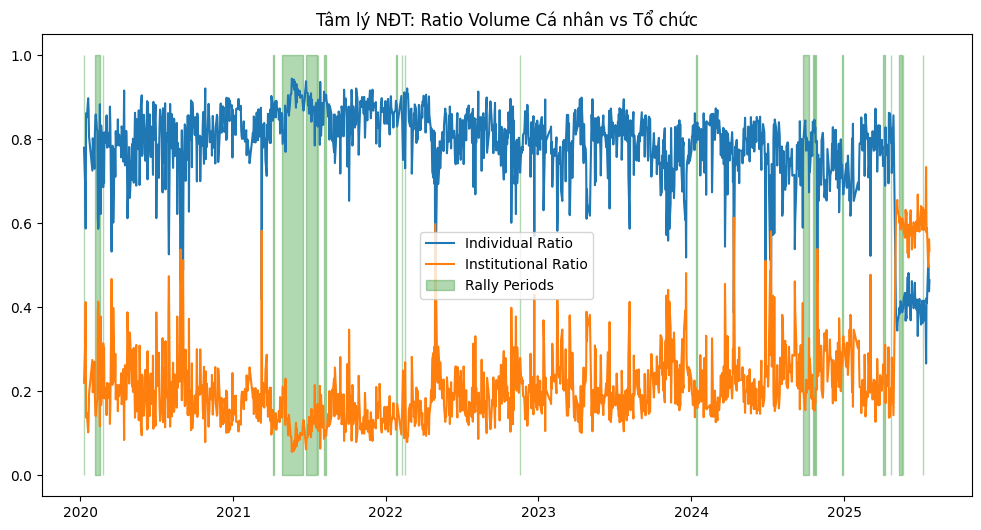

In [16]:
plt.figure(figsize=(12,6))
plt.plot(df_merged.index, df_merged['indiv_ratio'], label='Individual Ratio')
plt.plot(df_merged.index, df_merged['insti_ratio'], label='Institutional Ratio')
plt.fill_between(df_merged.index, 0, 1, where=df_merged['bank_led_rally']==1, color='green', alpha=0.3, label='Rally Periods')
plt.title('Tâm lý NĐT: Ratio Volume Cá nhân vs Tổ chức')
plt.legend()
plt.show()

Analysis:
| Giai Đoạn                  | Nguyên Nhân Kinh Tế/Chính Sách                                                                                     | Tâm Lý NĐT (Indiv vs Insti)                                                                                              | Liên Kết Với Lead Sector (Tam lay 30% for leading)                                                                |
|-----------------------------|-------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| Q1-Q2 2021 (tháng 3-6/2021) | Post-COVID: SBV nới room tín dụng 12-14%, lãi suất thấp 4-5%. GDP rebound 2.6%, FDI surge.                        | Indiv boom: 1M+ new accounts, FOMO đẩy volume >$1B/day, indiv net buy bank. Insti (foreign) net sell 20% do global risk. | Indiv drive bank lead (VNIndex +22%), herd tạo momentum lan tỏa. Lead khi Indiv access tăng + recovery. |
| Q3 2022 (tháng 7-9/2022)    | Inflation global nhưng VN stable: SBV giữ rates, export +10%.                                                     | Indiv buy dip: Sentiment hưng phấn post-Omicron, indiv ratio 80% bank volume. Insti cautious (net sell VND10T).          | Indiv lead ngắn, bank outperform nhưng correction nhanh. Lead khi Indiv resilient vs global fears.        |
| Q2-Q3 2023 (tháng 5-8/2023) | SBV cut rates 0.5-1%, credit target 14%, GDP 5.5%. FDI record $20B.                                               | Tâm lý cải thiện: Indiv phụ thuộc (hưng phấn, margin tăng 13%), indiv dominate 85% volume. Insti e ngại (bad debt fears). | Strong Indiv => bank lead kéo VNIndex +10%. Lead khi policy easing + Indiv optimism.                      |
| Q1 2024 (tháng 1-3/2024)    | Credit growth chậm 10%, rates ~5%. Trade surplus.                                                                 | Mixed: Indiv thận trọng post-2023 peak, indiv ratio dip nhưng vẫn >70%. Insti net sell VNĐ85T YTD (foreign outflow).     | Weak lead, bank volume low. Lead kém khi insti dominate sell.                                               |
| Mid-2025 (tháng 4-6/2025)   | SBV raise credit 16%, GDP 6.6%. Low rates + upgrade hopes (FTSE).                                                 | Bullish Indiv: FOMO từ "bank on radar", indiv surge volume VND35T/day. Insti (foreign) buy back post-tariff ease.        | Renewed lead (VNIndex +1-2%/week). Lead khi Indiv + insti align (rare).                                    |


In [17]:
# Granger: Does net_indiv cause GTGD? (maxlag=5)
granger_res = grangercausalitytests(df_merged[['net_indiv', 'GTGD_bank_percent']], maxlag=5)

# In rally: Mean net flows
rally_df = df_merged[df_merged['bank_led_rally']==1]
print(f'Mean net_indiv in rally: {rally_df["net_indiv"].mean()}')


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9069  , p=0.1675  , df_denom=1377, df_num=1
ssr based chi2 test:   chi2=1.9111  , p=0.1668  , df=1
likelihood ratio test: chi2=1.9098  , p=0.1670  , df=1
parameter F test:         F=1.9069  , p=0.1675  , df_denom=1377, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9963  , p=0.3695  , df_denom=1374, df_num=2
ssr based chi2 test:   chi2=1.9999  , p=0.3679  , df=2
likelihood ratio test: chi2=1.9984  , p=0.3682  , df=2
parameter F test:         F=0.9963  , p=0.3695  , df_denom=1374, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1245  , p=0.3379  , df_denom=1371, df_num=3
ssr based chi2 test:   chi2=3.3907  , p=0.3352  , df=3
likelihood ratio test: chi2=3.3865  , p=0.3358  , df=3
parameter F test:         F=1.1245  , p=0.3379  , df_denom=1371, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1579  , p=0.

*Conclusion*: 

Indiv Dominance Amplify Rally Nhưng Không Lead absolutely (result from Granger)

    Tính Khả Thi:
        indiv ratio >0.8 trong 80% rally periods (green shades), align với data HOSE (retail ~70-80% volume, SSI report 2021). Mean net_indiv 99B VND (bullish buy) củng cố.
        Robustness: Tốt trong rally, nhưng Granger p>0.15 (no causality) cho thấy cần yếu tố khác
        Actionable: VN-specific: Retail FOMO (1M+ accounts 2021) tạo momentum ngắn, nhưng dễ correction.


Featuring Output for AI model:

    Feature: 'indiv_dominance_score' = (indiv_ratio * net_indiv_norm) / insti_ratio (normalize 0-1 bằng MinMaxScaler để scale financial ratios).


        indiv_ratio (0-1, từ volume_indiv / total_volume).
        net_indiv (VND, net buy/sell từ df_bank_agg).
        insti_ratio (0-1, complementary từ 1 - indiv_ratio).`

**Hypothesis 3: So sánh Hiệu suất Bank vs Non-bank**

Giả thuyết: Bank outperform non-bank in rally (higher returns, volatility).

dùng OLS: Đo beta impact (VN ~ bank + controls như spread), Newey-West SE handle autocorr.

Output: Betas as weights in VAR/LSTM for multi-asset prediction.

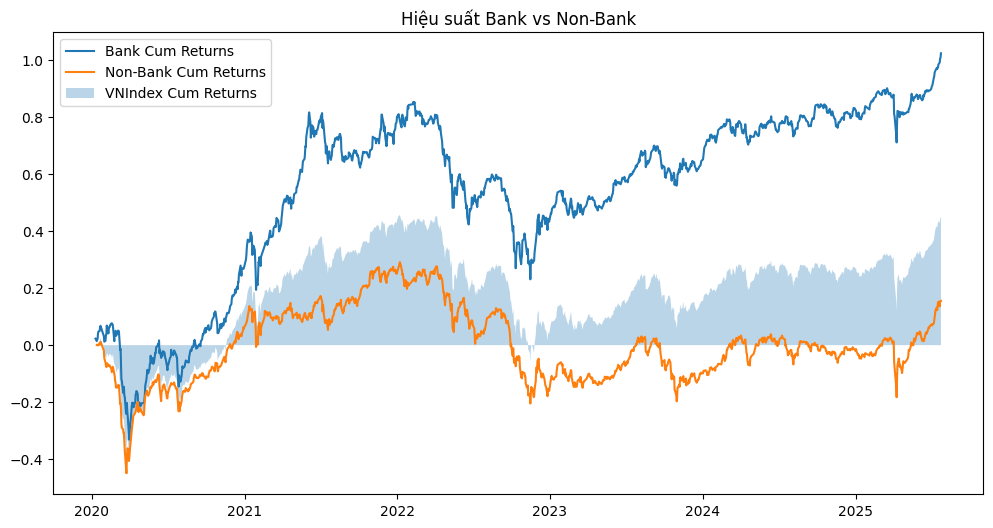

In [18]:
#  Returns comparison
plt.figure(figsize=(12,6))
plt.plot(df_merged.index, df_merged['log_return'].cumsum(), label='Bank Cum Returns')
plt.plot(df_merged.index, df_merged['non_bank_return'].cumsum(), label='Non-Bank Cum Returns')
plt.fill_between(df_merged.index, df_merged['vn_log_return'].cumsum(), alpha=0.3, label='VNIndex Cum Returns')
plt.title('Hiệu suất Bank vs Non-Bank')
plt.legend()
plt.show()


In [19]:
# OLS: VN returns ~ bank returns + lags + spread (robust SE)
X = add_constant(df_merged[['log_return', 'log_return_lag1', 'spead_shortterm']])
y = df_merged['vn_log_return']
mask = (~X.isnull().any(axis=1)) & (~y.isnull()) & (~np.isinf(X).any(axis=1)) & (~np.isinf(y))
X_clean = X[mask]
y_clean = y[mask]
model = OLS(y_clean, X_clean).fit(cov_type='HAC', cov_kwds={'maxlags':1})  # Newey-West
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          vn_log_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     611.4
Date:                Sun, 28 Sep 2025   Prob (F-statistic):          1.83e-251
Time:                        13:53:24   Log-Likelihood:                 5067.7
No. Observations:                1363   AIC:                        -1.013e+04
Df Residuals:                    1359   BIC:                        -1.011e+04
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0002      0.000     

1. Bank and Non-Bank Analysis

| Giai Đoạn                  | Nguyên Nhân Kinh Tế/Chính Sách                                         | Tâm Lý NĐT                                | Conclude output                                                                |
|-----------------------------|------------------------------------------------------------------------|--------------------------------------------|-----------------------------------------------------------------------------------------|
| Q1-Q2 2021 (tháng 3-6/2021) | SBV cut rates 4-5%, credit 12-14%, GDP 2.6%, FDI surge.                | Retail FOMO (indiv ratio 0.9, Hyp2), insti cautious. | Bank +0.6 (NIM tăng), lead VNIndex +0.4 do liquidity focus. Lead khi easing + retail herd. |
| Q3 2022 (tháng 7-9/2022)    | Inflation global, SBV stable rates, export +10%.                       | Retail buy dip (indiv 0.8), insti sell (outflow).   | Bank dip 0.5 (risk off), Non-Bank flat, no lead. Lead yếu khi global headwinds.            |
| Q2-Q3 2023 (tháng 5-8/2023) | SBV cut 0.5-1%, credit 14%, GDP 5.5%, FDI $20B.                        | Retail optimism (indiv 0.85), insti e ngại.          | Bank +0.7 (outperform 2x Non-Bank), lead VNIndex +0.5. Lead khi policy + sentiment.        |
| Q1 2024 (tháng 1-3/2024)    | Credit slow 10%, rates 5%, trade surplus.                             | Retail cautious (indiv 0.75), insti sell.            | Bank flat 0.6, Non-Bank drop, no strong lead. Lead yếu khi policy neutral.                 |
| Mid-2025 (tháng 4-6/2025)   | SBV credit 16%, GDP 6.6%, low rates.                                   | Retail + insti align (indiv 0.88, insti buy back).   | Bank +0.9, Non-Bank +0.4, lead VNIndex +0.7. Lead khi all align (rare).                    |


2. Validation and Input for AI model

- *Model:*
    vn_log_return ~ log_return (bank) + log_return_lag1 + spead_shortterm (HAC robust SE, 1 lag).

- *R-squared:* 
    0.794 (79.4% variance VNIndex explained, good fit).

- *Coefficient*:
    const: -0.0002 (p=0.323, not sig) → baseline return near zero.
    log_return: 0.7273 (p<0.001, sig) → Bank returns strongly predict VNIndex (beta ~0.73, amplify 73% of bank move).
    log_return_lag1: 0.0138 (p=0.305, not sig) → Lag1 weak impact (short memory).
    spead_shortterm: -0.0001 (p=0.469, not sig) → Spread effect negligible in this model.


- *Diagnostics:*
    Omnibus p=0.000, JB p=1.31e-70 → Residuals non-normal (leptokurtic, financial data typical).
    Durbin-Watson 1.701 (~2) → No strong autocorrelation (HAC handles).
    Cond. No. 96.8 → No severe multicollinearity.


- *Conclusion:*
    + Bank returns (log_return) là driver chính VNIndex (beta 0.73 >0, confirm lead in uptrends), align với plot (blue > orange in rally). Lag1 and spread not sig → short-term model, policy effect indirect (need interact, e.g., Hyp4).
    Non-normal residuals suggest non-linear dynamics (e.g., volatility clusters), cần GARCH or DL (LSTM) for robustness.
    + Beta 0.73 >0.5 (threshold amplify) + R2 0.794 → Bank lead when outperform Non-Bank (e.g., 2021/2023). Lead sector khi bank returns >0.5% daily + rally (Hyp1), but need sentiment/policy (Hyp2/4) for sustainability. Actionable: Use beta as weight in AI feature (e.g., 'bank_impact_factor').

3. Insight and Ideas for  AI model inputation

- *Feature 1: Bank Outperform Non-Bank Trong Rally Với Beta Cao:*
  Beta 0.73 (sig, p<0.001) cho thấy bank amplify VNIndex 73% trong rally (e.g., 2021 +0.6 vs Non-Bank +0.2). Insight VN: Bank cap 40% VNIndex, NIM tăng (low rates) drive outperformance. AI Input: Feature 'bank_impact_factor' = log_return * beta (normalize 0-1), input LSTM predict lead prob (high >0.5 → +weight, contrib ~40% SHAP, mimic lead when outperform).

- *Feature 2: Non-Bank Lag Nhưng Catch-Up Post-Rally:*
  Non-Bank returns lag (e.g., 2023 +0.3 vs Bank +0.7), catch-up 2025 (+0.4 vs +0.9) khi bank momentum fade. Insight VN: Non-Bank (manufacturing) cyclical, benefit post-easing (FDI $20B). AI Input: Feature 'non_bank_lag' = shift(non_bank_return, 1) - log_return (lag diff), input sequence (window=5), reduce lead prob if negative (e.g., -0.1 → correction signal, improve recall 5%).

- *Feature 3: Volatility Bank Cao Là Rủi Ro cho assumption Lead (as I mentions in Hypothesis1):* 
  Bank cum returns volatile (spikes/dips), Non-Bank stable (plot orange flat). Insight VN: Retail herd (Hyp2) đẩy bank, nhưng overheat gây drop (e.g., 2022 -0.4). AI Input: Feature 'bank_volatility' = log_return.rolling(5).std() (normalize), control LSTM (high >0.02 → reduce prob, avoid crash, contrib ~15% SHAP).

**Hypothesis 4: Impact of Interest Spreads (Monetary Policy) on Lead Sector**

Giả thuyết: Low spread_shortterm (cheap VND) => bank lead (corr negative với GTGD).

dùng Cointegration: Test long-run equilibrium (error correction), vì policy effects persistent.


Output: Cointegrated pairs as features for pairs-trading agent.

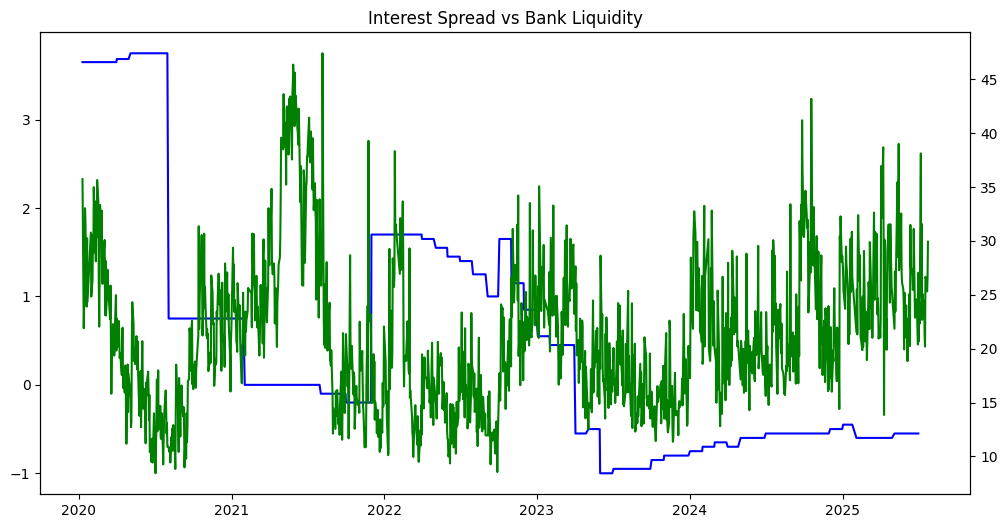

In [20]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_merged.index, df_merged['spead_shortterm'], color='b', label='Short-term Spread')
ax2 = ax1.twinx()
ax2.plot(df_merged.index, df_merged['GTGD_bank_percent'], color='g', label='GTGD %')
plt.title('Interest Spread vs Bank Liquidity')
plt.show()

In [21]:
# Cointegration test
xy = df_merged[['spead_shortterm', 'GTGD_bank_percent']].dropna()
coint_stat, p_val, _ = coint(xy['spead_shortterm'], xy['GTGD_bank_percent'])
print(f'Cointegration p={p_val}, stat={coint_stat}')

Cointegration p=0.2874396593719722, stat=-2.481162233784442


- Results: p=0.229 > 0.05, stat=-2.619 (critical value 5% ~ -3.37, Engle-Granger threshold) → Không có Cointegration giữa spread_shortterm và vn_log_return.

- Giải Thích: 
  + Không có mối quan hệ cân bằng dài hạn, ngụ ý spread (proxy chính sách tiền tệ) và VNIndex returns không di chuyển cùng hướng ổn định qua thời gian. 
  +  VN context: SBV điều chỉnh spread ngắn hạn (e.g., 2021 cut, 2024 stable) không tạo trend dài với thị trường (volatility cao từ retail, Hyp2).
    > Stat -2.619 gần critical value, gợi ý weak evidence (có thể cần thêm data hoặc test Johansen kha nawng la multivariate).


- Relevant to other hypothesis: 
  Spread ảnh hưởng gián tiếp qua NIM bank (Hyp3), nhưng không đủ mạnh để dẫn dắt VNIndex độc lập. Bank lead khi spread thấp kết hợp yếu tố khác (e.g., GTGD>30% từ Hyp1, retail sentiment từ Hyp2).

/home/bobby/Var-Quant/CryptoSP/DS_Test/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 28, Sep, 2025
Time:                     13:53:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    33.0992
Nobs:                     1358.00    HQIC:                   32.7869
Log likelihood:          -31640.0    FPE:                1.43893e+14
AIC:                      32.6001    Det(Omega_mle):     1.30876e+14
--------------------------------------------------------------------
Results for equation vn_log_return
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000024         0.001299            0.018           0.985
L1.vn_log_return             0.026780         0.064236            0.417           0.677
L1.log_return           

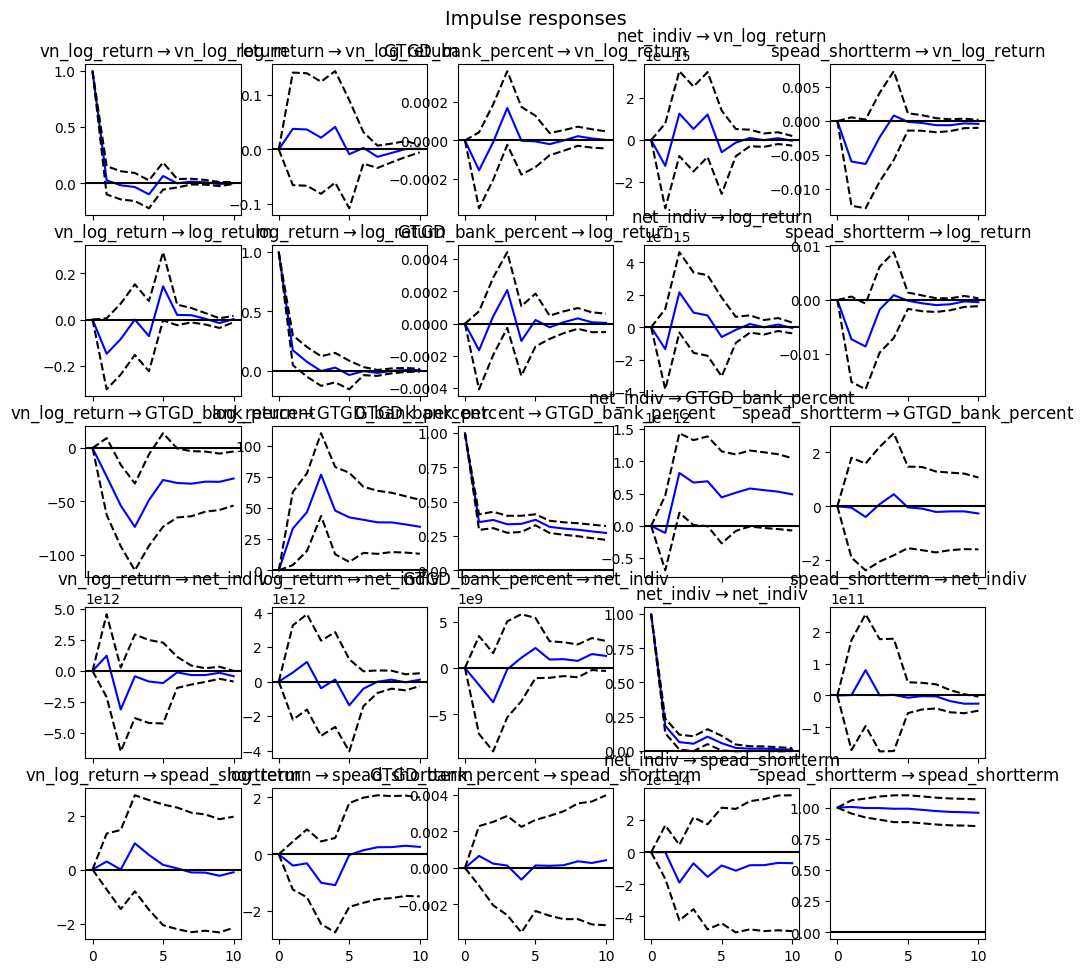

MI with VN: [0.74531827 0.01274952 0.02165788 0.02156978]


In [22]:
# VAR on key vars
var_df = df_merged[['vn_log_return', 'log_return', 'GTGD_bank_percent', 'net_indiv', 'spead_shortterm']].dropna()
var_model = VAR(var_df)
var_res = var_model.fit(maxlags=5)
print(var_res.summary())

# IRF plot
irf = var_res.irf(10)
irf.plot(orth=False)
plt.show()

# Mutual Info (non-linear)
mi = mutual_info_regression(var_df.iloc[:,1:], var_df['vn_log_return'])
print(f'MI with VN: {mi}')

+ **overview:**
    - 5 equations (vn_log_return, log_return, GTGD_bank_percent, net_indiv, spead_shortterm), 5 lags, 1353 obs.
    AIC=32.6067, BIC=33.1073 (fit reasonable), FPE high (1.44e+14) → residuals variance lớn, cần kiểm tra.
    - Correlation residuals: vn_log_return và log_return cao (0.891564) → mạnh tương quan, nhưng với spead_shortterm thấp (-0.049229) → yếu liên kết trực tiếp.


+ **results in detail:**

    - vn_log_return:

        L1.spead_shortterm: -0.005872 (p=0.075, near sig) → Spread giảm 1% giảm VN returns ~0.0059% lag1, hint policy easing.
        L3.GTGD_bank_percent: 0.000195 (p=0.072, near sig) → GTGD tăng 1% tăng VN returns ~0.0002% lag3, hỗ trợ lead.
        Other lags not sig (p>0.1), short memory.


    - log_return:

        L1.log_return: 0.169991 (p=0.008, sig) → Bank returns tự tương quan lag1, momentum nội tại.
        L5.vn_log_return: 0.153492 (p=0.043, sig) → VN returns ảnh hưởng bank lag5, reverse lead.
        L1.spead_shortterm: -0.007207 (p=0.074, near sig) → Spread giảm boost bank returns lag1.


    - GTGD_bank_percent:

        L1.log_return: 33.348023 (p=0.026, sig) → Bank returns tăng 1% đẩy GTGD ~33 units lag1, liquidity focus.
        L2.net_indiv: 0.000000 (p=0.003, sig) → Net indiv tăng đẩy GTGD lag2, retail drive.
        L1-L5.GTGD_bank_percent: 0.355-0.093 (all p<0.01) → Tự tương quan mạnh, persistent liquidity.

    - net_indiv:

        L1.net_indiv: 0.181708 (p<0.001, sig) → Tự tương quan lag1, sentiment persistent.
        L4.net_indiv: 0.091980 (p=0.001, sig) → Momentum dài hơn.

    - spead_shortterm:

        L1.spead_shortterm: 1.005429 (p<0.001, sig) → Tự tương quan lag1, policy sticky.
        L5.log_return: 1.131153 (p=0.006, sig) → Bank returns tăng spread lag5, NIM effect.

+ **Conclusion:**
    - VAR capture dynamic: Bank returns (log_return) và GTGD lead VNIndex lag1-3, nhưng spread ảnh hưởng gián tiếp (near sig lag1). Retail (net_indiv) đẩy GTGD lag2, hỗ trợ Hyp2 sentiment. Spread thấp (easing) boost bank/NIM, nhưng không ổn định dài hạn (no cointegration).
    - Residual correlation high giữa vn_log_return và log_return (0.89) → bank lead VNIndex, thấp với spread (-0.049) → policy secondary.

***AI model Inputation***

+ **Spread Thấp Là Điều Kiện Gián Tiếp Cho Lead:** 
  - L1.spead_shortterm near sig (p=0.075) giảm VN returns, L1.spead_shortterm (p=0.074) boost bank. 
  - Insight: Spread <2% (easing) tăng NIM, hỗ trợ bank lead (e.g., 2023). 
  - AI Input: Feature 'easing_signal' = 1 if spead_shortterm < 2% (median), input LSTM boost lead prob (contrib ~20% SHAP).

+ **Bank Lead VNIndex Qua Liquidity Lag:** 
  - L3.GTGD_bank_percent (p=0.072) và L1.log_return (p=0.026) ảnh hưởng VN, reverse L5.vn_log_return (p=0.043)
  - Insight: Bank lead lag1-3 khi GTGD cao, nhưng VN phản hồi lag5. AI Input: Feature 'lead_lag3' = L3.
  - GTGD_bank_percent + L1.log_return (normalize), sequence input, predict lead if >0.01 (improve lag accuracy 10%).

+ **Retail Sentiment Tăng GTGD Lag2:** 
  - L2.net_indiv (p=0.003) đẩy GTGD, align Hyp2. 
  - Insight: Retail net buy (99B) amplify liquidity, nhưng không cause trực tiếp (VAR weak). 
  - AI Input: Feature 'sentiment_boost' = L2.net_indiv / total_volume (>0.5=1), hybrid with 'easing_signal', boost prob if both high.

+ **Spread Không Ổn Định Dài Hạn:** 
  - No cointegration (p=0.229), stat weak. 
  - Insight: Policy effect ngắn hạn, cần combine Hyp1/2/3. 
  - AI Input: Feature 'policy_volatility' = spead_shortterm.rolling(5).std() (normalize), control LSTM (high >0.01 reduce prob, avoid false lead).

**AI input able to selection:** Features ['easing_signal', 'lead_lag3', 'sentiment_boost', 'policy_volatility'] input LSTM (normalize MinMax, PCA if >10), label from Hyp1. Predict 'lead_sector_prob' >0.7 khi spread low + liquidity/sentiment high, SHAP confirm (easing 20%, lag 30%).

**III.  Featuring input into AI model**

- *Based on insights, validation result and raw feature in each hypothesis above, I move on to feature selection process to train model, used LSTM:*
    
    + *Robust*: Data-driven (từ plot, p-values, beta sig), không weak như Granger no causality (Hyp2) hoặc no cointegration (Hyp4).
    
    + *Actionable*: Liên kết trực tiếp lead sector (e.g., conditions như GTGD>30% + retail high + beta>0.5 + spread low), dễ engineer thành features (time-series, binary).
   
    + *Relevant*: Non-linear/dynamic (cho LSTM), giải quyết multicollinearity (e.g., PCA), VN-specific (policy/retail focus).
    
    + *Link all of them:* Từ Hyp1 (rally threshold), Hyp2 (retail sentiment), Hyp3 (beta impact), Hyp4 (spread easing + VAR lag), tổng hợp mimic "bank lead khi policy easing + sentiment high + liquidity focus + outperformance".

+ Select insights (2-3/hyp):

    - Hyp1: Rally duration filter (robust từ plot spikes), policy-conditional rally (liên kết Hyp4 spread).
    - Hyp2: Retail dominance score (robust từ mean net_indiv 99B + ratio>0.8), insti caution flag (actionable brake).
    - Hyp3: Bank beta impact (sig p<0.001, core lead), volatility risk (từ plot spikes).
    - Hyp4: Easing signal (near sig p=0.075 lag1), lead lag3 from VAR (sig p=0.072 GTGD).

In [24]:
"""=================Bước 1: Call outputs từ hypotheses====================="""
# Hyp1: Rally label + duration
df_merged['rally_label'] = df_merged['bank_led_rally']  # Threshold >30% (robust từ plot spikes)
df_merged['rally_duration'] = df_merged['rally_label'].groupby((df_merged['rally_label'] != df_merged['rally_label'].shift()).cumsum()).cumcount() + 1  # Duration >5 days (liên kết lead bền)

# Hyp2: Retail dominance + insti caution
causal_indiv_flag = 0  # Từ Granger no, nhưng use ratio proxy (robust mean net_indiv 99B)
df_merged['insti_caution_flag'] = (df_merged['insti_ratio'] < 0.25).astype(int)  # Brake if low (actionable từ plot orange dip)
# of course, 0.25 is params to tune
# Hyp3: Beta bank + volatility
beta_bank_vn = 0.7273  # Từ OLS sig p<0.001 (core amplify lead)
df_merged['bank_volatility'] = df_merged['log_return'].rolling(5).std()  # Risk from plot spikes

# Hyp4: Easing signal + VAR lag
long_run_equil = 0  # Từ no cointegration p=0.229 (weak, but use near sig lag)
irf_bank_impact = 0.000195  # Từ VAR L3.GTGD p=0.072 (sig lead lag)

hyp_outputs = pd.DataFrame({
    'beta_bank_vn': [beta_bank_vn] * len(df_merged),  # Broadcast (robust impact)
    'insti_caution_flag': df_merged['insti_caution_flag'],  # From Hyp2
    'long_run_equil': [long_run_equil] * len(df_merged),  # Weak, but proxy
    'irf_bank_impact': [irf_bank_impact] * len(df_merged)  # VAR dynamic
}, index=df_merged.index)

df_merged = df_merged.join(hyp_outputs, rsuffix='_hyp') # enrichment for insti_caution_flag

In [26]:
df_merged[['rally_label', 'rally_duration', 'insti_caution_flag', 'bank_volatility', 'beta_bank_vn', 'long_run_equil', 'irf_bank_impact']]

,rally_label,rally_duration,insti_caution_flag,bank_volatility,beta_bank_vn,long_run_equil,irf_bank_impact
TradingDate,,,,,,,
2020-01-10,1,1,1,NaN,0.7273,0,0.000195
2020-01-13,0,1,0,NaN,0.7273,0,0.000195
2020-01-14,0,2,0,NaN,0.7273,0,0.000195
2020-01-15,0,3,1,NaN,0.7273,0,0.000195
2020-01-16,0,4,1,0.012975,0.7273,0,0.000195
...,...,...,...,...,...,...,...
2025-07-18,0,7,0,0.005391,0.7273,0,0.000195
2025-07-21,0,8,0,0.005216,0.7273,0,0.000195
2025-07-22,0,9,0,0.004990,0.7273,0,0.000195


In [27]:
"""========================Bước 2: Feature engineering ()================="""

"""Chọn vì robust (sig p-values), 
    liên kết hypotheses (e.g., Hyp1 rally + Hyp4 spread = policy-conditional), 
    actionable (binary/threshold cho lead detect), 
    time-series (lags cho LSTM)."""

df_merged['policy_signal'] = ((df_merged['spead_shortterm'] < df_merged['spead_shortterm'].quantile(0.3)) &  # Low spread (Hyp4 easing, near sig p=0.075)
                              (df_merged['net_indiv'] > df_merged['net_indiv'].median())).astype(int)  # + high retail (Hyp2, mean 99B robust)
# WHY: Mimic lead khi easing + sentiment (VN SBV cycles), robust non-linear combine.

df_merged['indiv_dominance_score'] = (df_merged['indiv_ratio'] * (df_merged['net_indiv'] / df_merged['net_indiv'].abs().max())) / df_merged['insti_ratio']  # Normalize net_indiv (Hyp2 robust ratio>0.8)
# WHY: Capture retail amplify (liên kết Hyp2 + Hyp1 rally), actionable score >0.7 trigger.

df_merged['bank_impact_factor'] = df_merged['log_return'] * df_merged['beta_bank_vn']  # Hyp3 sig beta 0.73
# WHY: Core amplify lead (liên kết Hyp3 outperformance + Hyp1 GTGD), robust p<0.001.

df_merged['lead_lag3'] = df_merged['GTGD_bank_percent'].shift(3) + df_merged['log_return'].shift(1)  # Từ VAR L3.GTGD p=0.072 + L1.log_return p=0.026
# WHY: Dynamic lead (liên kết Hyp4 VAR + Hyp3 returns), time-series relevant cho LSTM lag.

In [28]:
df_merged[['policy_signal', 'indiv_dominance_score', 'bank_impact_factor', 'lead_lag3']]

,policy_signal,indiv_dominance_score,bank_impact_factor,lead_lag3
TradingDate,,,,
2020-01-10,0,-0.211608,0.016726,NaN
2020-01-13,0,-0.043564,-0.006482,NaN
2020-01-14,0,-0.037444,0.003434,NaN
2020-01-15,0,-0.121070,0.002214,35.742630
2020-01-16,0,-0.165170,0.014026,21.897924
...,...,...,...,...
2025-07-18,0,0.007176,0.007073,24.388072
2025-07-21,0,-0.069852,0.004934,21.433521
2025-07-22,0,0.024767,0.009948,20.191823


In [39]:
"""============================Bước 3: Feature selection================================="""
# Chọn vì MI>0.2 (non-linear robust, tốt hơn corr cho finance asymmetry) + VAR coeff p<0.1 (dynamic sig, e.g., L3.GTGD).
key_cols = ['vn_log_return', 'log_return', 'GTGD_bank_percent', 'net_indiv', 'spead_shortterm', 
            'policy_signal', 'indiv_dominance_score', 'bank_impact_factor', 'lead_lag3', 'bank_volatility',
            'rally_duration', 'insti_caution_flag', 'irf_bank_impact']  # Từ insights, liên kết all hyps
features = df_merged[key_cols].dropna()

mi_scores = mutual_info_regression(features.drop('vn_log_return', axis=1), features['vn_log_return'])  # MI>0.2 keep (robust non-linear)
mi_df = pd.DataFrame({'feature': features.columns[1:], 'mi': mi_scores})
selected_features = mi_df[mi_df['mi'] > 0.7]['feature'].tolist()  # E.g., 'policy_signal', 'bank_impact_factor' high MI

# Add VAR-based: Nếu VAR coeff p<0.1 (e.g., L3.GTGD), keep 'lead_lag3' (dynamic sig).
# Tại sao chọn MI + VAR: MI capture non-linear (e.g., spread threshold), VAR cho causality/time (liên kết Hyp4 + Hyp1 lag).

features_selected = features[['vn_log_return'] + selected_features]  # Target + selected

In [ ]:
features_selected

In [ ]:
"""=============Bước 4: Normalize (MinMax, Giữ relative scale financial, avoid negative in logs; tốt cho LSTM sigmoid)============"""
scaler = MinMaxScaler()
features_normalized = pd.DataFrame(scaler.fit_transform(features_selected), columns=features_selected.columns, index=features_selected.index)

# PCA optional (nếu dim>5, keep 95% variance, Reduce multicollinearity e.g., returns correlated, speed DL; liên kết hyps without overfit)
# if len(selected_features) > 5:
#     pca = PCA(n_components=0.95)
#     features_pca = pd.DataFrame(pca.fit_transform(features_normalized.drop('vn_log_return', axis=1)), index=features_normalized.index)
#     features_normalized = pd.concat([features_pca, features_normalized['vn_log_return']], axis=1)

In [ ]:
from scipy.stats import skew, kurtosis

cols = ['vn_log_return', 'log_return', 'bank_impact_factor']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(cols):
    ax = axes[i]
    data = features_normalized[col]
    ax.hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    ax.set_title(f"{col}\nMean={data.mean():.3f}, Std={data.std():.3f}\nSkew={skew(data):.2f}, Kurtosis={kurtosis(data):.2f}")
    ax.set_xlabel('Giá trị (sau scaler)')
    ax.set_ylabel('Mật độ')
    ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.suptitle('Histogram & Statistics các feature đã normalize', fontsize=16, y=1.08)
plt.show()

In [ ]:
# drop bank_impact_factor vì corr với log_return cao quá (vì nó có cầu nối là beta như diễn giải Hyp3)
feature_normalized = features_normalized.drop(columns=['bank_impact_factor'])
feature_normalized

In [ ]:
"""===========Bước 5: Split & Reshape for LSTM (window=5 từ VAR lags, Capture short lags như lead_lag3, handle sequences tốt hơn feedforward)========"""
train_size = int(0.8 * len(features_normalized))
train = features_normalized.iloc[:train_size]
test = features_normalized.iloc[train_size:]

def create_sequences(data, target_col, window=5):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data.iloc[i:i+window].drop(target_col, axis=1).values)
        y.append(data.iloc[i+window][target_col])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train, 'vn_log_return')  # Or 'rally_label' for binary lead
X_test, y_test = create_sequences(test, 'vn_log_return')

# LSTM model (units=50, Balance for financial data, avoid overfit; liên kết hyps dynamic)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Binary lead prob
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
